In [1]:
import pandas as pd
import numpy as np
from sklearn.ensemble import BaggingClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from imblearn.combine import SMOTETomek
from scipy.stats import randint, uniform
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report, roc_auc_score
from sklearn.model_selection import RandomizedSearchCV, train_test_split, StratifiedKFold
from sklearn.preprocessing import LabelEncoder as LE
from sklearn.model_selection import learning_curve
import matplotlib.pyplot as plt
import warnings
import lightgbm as lgb
from catboost import CatBoostClassifier
from sklearn.compose import ColumnTransformer
from sklearn.impute import SimpleImputer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import OneHotEncoder, StandardScaler
from sklearn.tree import export_graphviz
import seaborn as sns

warnings.filterwarnings("ignore")
print("All libraries loaded")

All libraries loaded


In [2]:
try:
    data = pd.read_csv('informacion_completa_imagenes_V2.csv')
    print("Datos cargados exitosamente.")
except Exception as e:
    print(f"Error al cargar los datos: {e}")
    
print(data.info())

print(data.columns)


Datos cargados exitosamente.
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 226 entries, 0 to 225
Data columns (total 23 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   nombre de la imagen               226 non-null    object 
 1   Ángulo entre manecillas           226 non-null    float64
 2   Ángulo manecillas 2pm             226 non-null    float64
 3   Ángulo manecillas 11am            226 non-null    float64
 4   Lowest point                      226 non-null    object 
 5   longitud_manecilla_2pm            226 non-null    float64
 6   longitud_manecilla_11am           226 non-null    float64
 7   Números detectados correctamente  226 non-null    int64  
 8   Números con error espacial        226 non-null    int64  
 9   Números algo detectado            226 non-null    int64  
 10  Total numeros detectados          226 non-null    int64  
 11  Puntuacion contorno               226 non-

In [3]:

data = data[data['Tipo'] != 'PR']

data = data[data['Tipo'] != 'HC']

data = data[data['Diagnostico '] != 'CN']

conteo_clases = data['Diagnostico '].value_counts()

print(conteo_clases)

Diagnostico 
PDD    43
MCI    33
Name: count, dtype: int64


In [4]:
data = data.astype({col: 'float64' for col in data.select_dtypes(include='bool').columns})
data[['lowest_point_x', 'lowest_point_y']] = data['Lowest point'].str.strip('()').str.split(',', expand=True).astype(float)
data['longitud_relativa_2pm'] = data['longitud_manecilla_2pm' ] / data['Area Circulo']
data['longitud_relativa_11pm'] = data['longitud_manecilla_11am' ] / data['Area Circulo']

data.dropna(subset=['Tipo'], inplace=True)

data.drop(columns=['nombre de la imagen','longitud_manecilla_2pm','longitud_manecilla_11am','Lowest point','Tipo'],inplace=True)


data['TipoDeDiagnostico'] = data['Diagnostico '].map({'CN': 1, 'MCI': 2, 'PDD': 3})
data.drop(columns=['Diagnostico '], inplace=True)

data = data.dropna()

conteo_clases = data['TipoDeDiagnostico'].value_counts()

print(conteo_clases)
print(data.info())

TipoDeDiagnostico
3    35
2    31
Name: count, dtype: int64
<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2 to 225
Data columns (total 22 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           66 non-null     float64
 1   Ángulo manecillas 2pm             66 non-null     float64
 2   Ángulo manecillas 11am            66 non-null     float64
 3   Números detectados correctamente  66 non-null     int64  
 4   Números con error espacial        66 non-null     int64  
 5   Números algo detectado            66 non-null     int64  
 6   Total numeros detectados          66 non-null     int64  
 7   Puntuacion contorno               66 non-null     int64  
 8   Puntuacion manecillas             66 non-null     int64  
 9   Puntuacion numeros                66 non-null     int64  
 10  puntuacion final                  66 non-null     int64  
 11  Area Circulo     

In [5]:
X = data.drop(columns=['TipoDeDiagnostico'])
y = data['TipoDeDiagnostico']

X = X.dropna()
y = y[X.index]

numerical_features = X.select_dtypes(include=['int64', 'float64']).columns
categorical_features = X.select_dtypes(include=['object', 'category']).columns

print(X.info())
print(y.info())

<class 'pandas.core.frame.DataFrame'>
Index: 66 entries, 2 to 225
Data columns (total 21 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   Ángulo entre manecillas           66 non-null     float64
 1   Ángulo manecillas 2pm             66 non-null     float64
 2   Ángulo manecillas 11am            66 non-null     float64
 3   Números detectados correctamente  66 non-null     int64  
 4   Números con error espacial        66 non-null     int64  
 5   Números algo detectado            66 non-null     int64  
 6   Total numeros detectados          66 non-null     int64  
 7   Puntuacion contorno               66 non-null     int64  
 8   Puntuacion manecillas             66 non-null     int64  
 9   Puntuacion numeros                66 non-null     int64  
 10  puntuacion final                  66 non-null     int64  
 11  Area Circulo                      66 non-null     float64
 12  Circularidad  

Datos de entrenamiento: (48, 21), Datos de validación: Datos de prueba ciega: (14, 21)


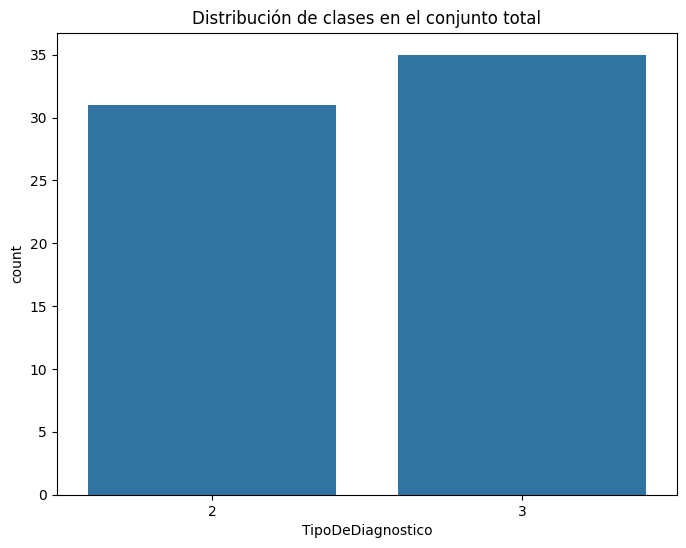

TipoDeDiagnostico
3    35
2    31
Name: count, dtype: int64


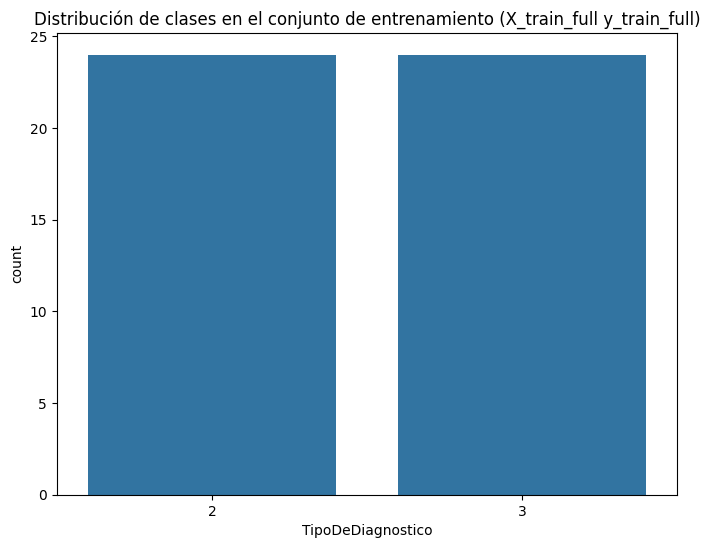

TipoDeDiagnostico
3    24
2    24
Name: count, dtype: int64


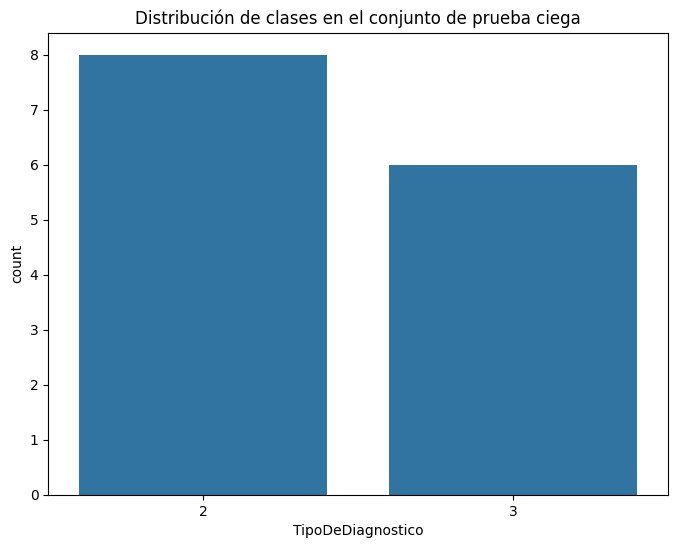

TipoDeDiagnostico
2    8
3    6
Name: count, dtype: int64


In [6]:
X_train, X_test_blind, y_train, y_test_blind = train_test_split(X, y, test_size=0.2, random_state=42)  

smote = SMOTETomek(random_state=42)
X_train_full, y_train_full = smote.fit_resample(X_train, y_train)

print(f"Datos de entrenamiento: {X_train_full.shape}, Datos de validación: Datos de prueba ciega: {X_test_blind.shape}")

plt.figure(figsize=(8,6))
sns.countplot(x=y)
plt.title('Distribución de clases en el conjunto total')
plt.show()
print(y.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_train_full)
plt.title('Distribución de clases en el conjunto de entrenamiento (X_train_full y_train_full)')
plt.show()
print(y_train_full.value_counts())

plt.figure(figsize=(8,6))
sns.countplot(x=y_test_blind)
plt.title('Distribución de clases en el conjunto de prueba ciega')
plt.show()
print(y_test_blind.value_counts())

CODIGO DE LGBM

In [7]:
lgb_model = lgb.LGBMClassifier(random_state=42)

param_dist_lgbm = {
    'num_leaves': [31, 50, 100, 150, 200],
    'max_depth': [-1, 5, 10, 15, 20],
    'learning_rate': [0.1, 0.01, 0.05, 0.005, 0.001],
    'n_estimators': [100, 200, 300, 500],
    'subsample': [0.6, 0.8, 1.0],
    'colsample_bytree': [0.6, 0.8, 1.0],
    'min_child_samples': [20, 30, 50],
    'min_child_weight': [1e-3, 1e-2, 1e-1, 1],
    'reg_alpha': [0, 0.1, 1, 10],
    'reg_lambda': [0, 0.1, 1, 10]
}


random_search_lgbm = RandomizedSearchCV(
    estimator=lgb_model,
    param_distributions=param_dist_lgbm,
    n_iter=50,  
    scoring='f1',
    cv=5,
    random_state=42,
    n_jobs=-1
)

In [8]:
random_search_lgbm.fit(X_train_full, y_train_full)

y_val_pred = random_search_lgbm.best_estimator_.predict(X_train_full)

[LightGBM] [Warning] There are no meaningful features which satisfy the provided configuration. Decreasing Dataset parameters min_data_in_bin or min_data_in_leaf and re-constructing Dataset might resolve this warning.
[LightGBM] [Warning] Found whitespace in feature_names, replace with underlines
[LightGBM] [Info] Number of positive: 24, number of negative: 24
[LightGBM] [Info] Total Bins 0
[LightGBM] [Info] Number of data points in the train set: 48, number of used features: 0
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] Stopped training because there are no more leaves that meet the split requirements
[LightGBM] [Warning] S

In [9]:
y_val_pred_lgmb = random_search_lgbm.predict(X_train_full)

print("Evaluación en el conjunto de validación con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_train_full, y_val_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train_full, y_val_pred_lgmb, average='weighted'):.4f}")


Evaluación en el conjunto de validación con el modelo lgbm:
Accuracy: 0.5000
Precision: 0.2500
Recall: 0.5000
F1 Score: 0.3333


In [10]:
y_test_blind_pred_lgbm = random_search_lgbm.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo lgbm:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_lgbm):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_lgbm, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_blind, y_test_blind_pred_lgbm))

Evaluación en conjunto de prueba ciega con el modelo lgbm:
Accuracy: 0.5714
Precision: 0.3265
Recall: 0.5714
F1 Score: 0.4156

Reporte de clasificación:
              precision    recall  f1-score   support

           2       0.57      1.00      0.73         8
           3       0.00      0.00      0.00         6

    accuracy                           0.57        14
   macro avg       0.29      0.50      0.36        14
weighted avg       0.33      0.57      0.42        14



In [11]:
y_test_pred_lgmb = random_search_lgbm.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modleo lgbm:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_lgmb):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_lgmb, average='weighted'):.4f}")

Evaluación en conjunto train original con el modleo lgbm:
Accuracy: 0.4423
Precision: 0.1956
Recall: 0.4423
F1 Score: 0.2713


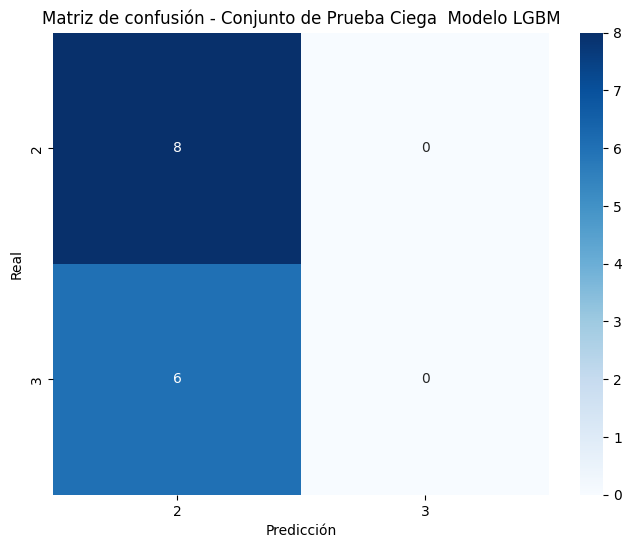

In [12]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(y_test_blind, y_test_blind_pred_lgbm)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega  Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

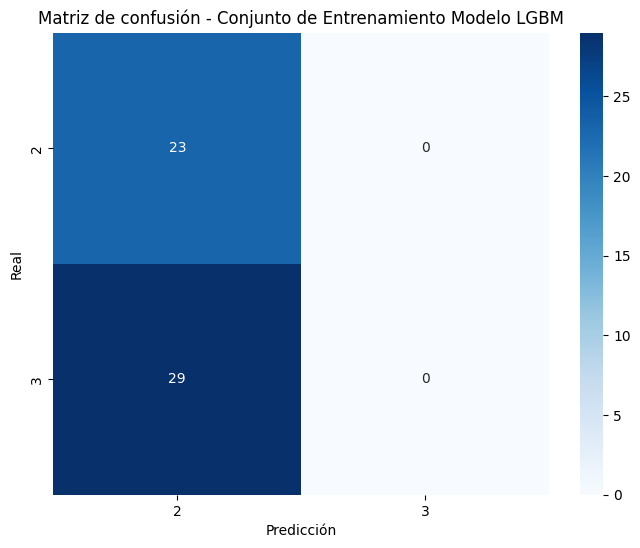

In [13]:
cm = confusion_matrix(y_train, y_test_pred_lgmb)
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento Modelo LGBM')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

CATBOOST

In [14]:
catboost_model = CatBoostClassifier(random_state=42, silent=True)

param_dist_cat = {
    'depth': [4, 6, 10],
    'learning_rate': [0.01, 0.05, 0.1],
    'iterations': [200, 500, 1000],
    'l2_leaf_reg': [1, 3, 5, 7],
    'border_count': [32, 64, 128]
}
random_search_cat = RandomizedSearchCV(
    estimator=catboost_model, 
    param_distributions=param_dist_cat, 
    n_iter=20,  
    scoring='f1', 
    cv=5, 
    verbose=1, 
    random_state=42, 
    n_jobs=-1
)

In [15]:
random_search_cat.fit(X_train_full, y_train_full)

y_pred_lgbm = random_search_cat.best_estimator_.predict(X_train_full)
print("Mejor hiperparámetro encontrado:", random_search_cat.best_params_)

Fitting 5 folds for each of 20 candidates, totalling 100 fits
Mejor hiperparámetro encontrado: {'learning_rate': 0.01, 'l2_leaf_reg': 1, 'iterations': 1000, 'depth': 4, 'border_count': 64}


In [16]:
y_test_blind_pred_cat = random_search_cat.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred_cat):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred_cat, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_blind, y_test_blind_pred_cat))

Evaluación en conjunto de prueba ciega con el modelo catboost:
Accuracy: 0.7857
Precision: 0.7959
Recall: 0.7857
F1 Score: 0.7868

Reporte de clasificación:
              precision    recall  f1-score   support

           2       0.86      0.75      0.80         8
           3       0.71      0.83      0.77         6

    accuracy                           0.79        14
   macro avg       0.79      0.79      0.78        14
weighted avg       0.80      0.79      0.79        14



In [17]:
y_test_pred_cat = random_search_cat.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original con el modelo catboost:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred_cat):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred_cat, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred_cat, average='weighted'):.4f}")

Evaluación en conjunto train original con el modelo catboost:
Accuracy: 1.0000
Precision: 1.0000
Recall: 1.0000
F1 Score: 1.0000


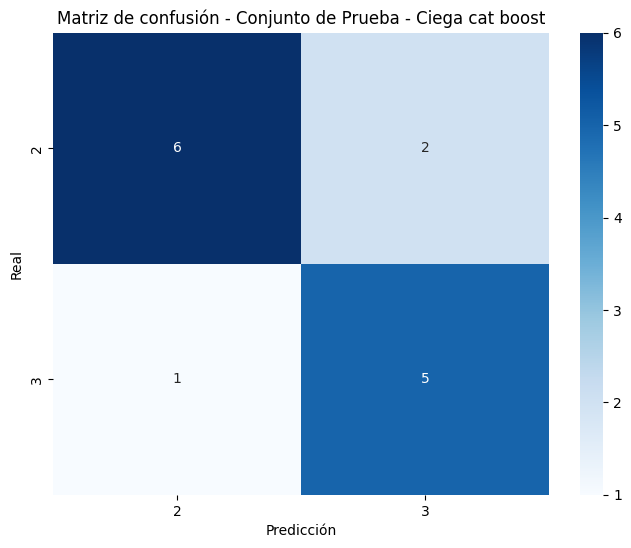

In [18]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba - Ciega cat boost')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

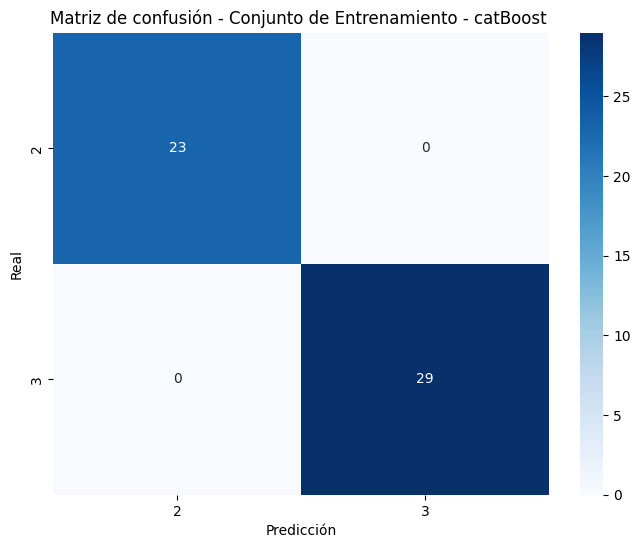

In [19]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred_cat)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento - catBoost ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Bagging

In [20]:
param_grid = {
    'estimator__max_depth': [3, 5, 7, None],
    'estimator__min_samples_split': [2, 5, 10],  
    'estimator__min_samples_leaf': [1, 2, 4],  
    'estimator__max_features': ['sqrt', 'log2'], 
    'n_estimators': [10, 50, 100, 200],  
    'max_samples': [0.5, 0.75, 1.0], 
    'bootstrap': [True, False], 
    'bootstrap_features': [True, False],  
    'oob_score': [True, False],  
    'warm_start': [True, False]  
}
bagging = BaggingClassifier(estimator=DecisionTreeClassifier(), random_state=42)
cv_strategy = StratifiedKFold(n_splits=10, shuffle=True, random_state=42)

random_search = RandomizedSearchCV(
    estimator = bagging, 
    param_distributions=param_grid, 
    n_iter=50, 
    cv=cv_strategy, 
    random_state=42, 
    n_jobs=-1,
    scoring='f1',
    verbose=2
)


In [21]:
random_search.fit(X_train_full, y_train_full)
print("Mejores hiperparámetros encontrados:", random_search.best_params_)

Fitting 10 folds for each of 50 candidates, totalling 500 fits
Mejores hiperparámetros encontrados: {'warm_start': True, 'oob_score': False, 'n_estimators': 50, 'max_samples': 0.75, 'estimator__min_samples_split': 5, 'estimator__min_samples_leaf': 4, 'estimator__max_features': 'sqrt', 'estimator__max_depth': 3, 'bootstrap_features': True, 'bootstrap': False}


In [23]:
y_test_blind_pred = random_search.best_estimator_.predict(X_test_blind)
print("Evaluación en conjunto de prueba ciega:")
print(f"Accuracy: {accuracy_score(y_test_blind, y_test_blind_pred):.4f}")
print(f"Precision: {precision_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_test_blind, y_test_blind_pred, average='weighted'):.4f}")
print("\nReporte de clasificación:\n" + classification_report(y_test_blind, y_test_blind_pred))

Evaluación en conjunto de prueba ciega:
Accuracy: 0.7143
Precision: 0.7143
Recall: 0.7143
F1 Score: 0.7143

Reporte de clasificación:
              precision    recall  f1-score   support

           2       0.75      0.75      0.75         8
           3       0.67      0.67      0.67         6

    accuracy                           0.71        14
   macro avg       0.71      0.71      0.71        14
weighted avg       0.71      0.71      0.71        14



In [24]:
y_test_pred = random_search.best_estimator_.predict(X_train)
print("Evaluación en conjunto train original:")
print(f"Accuracy: {accuracy_score(y_train, y_test_pred):.4f}")
print(f"Precision: {precision_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"Recall: {recall_score(y_train, y_test_pred, average='weighted'):.4f}")
print(f"F1 Score: {f1_score(y_train, y_test_pred, average='weighted'):.4f}")

Evaluación en conjunto train original:
Accuracy: 0.9423
Precision: 0.9432
Recall: 0.9423
F1 Score: 0.9424


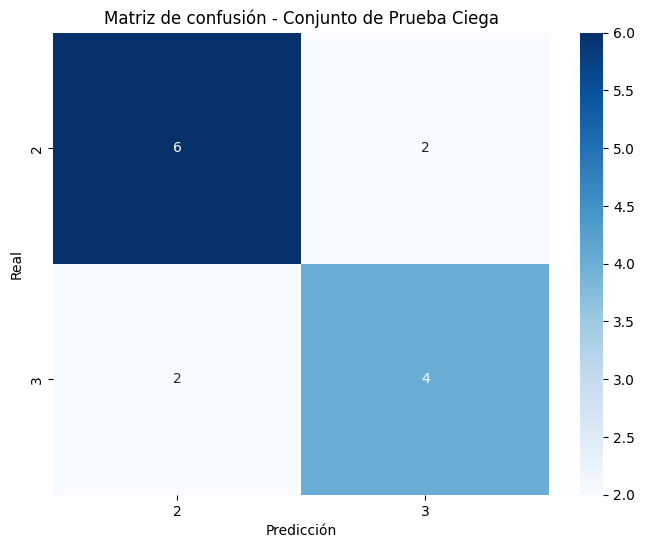

In [25]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_test_blind, y_test_blind_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Prueba Ciega')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

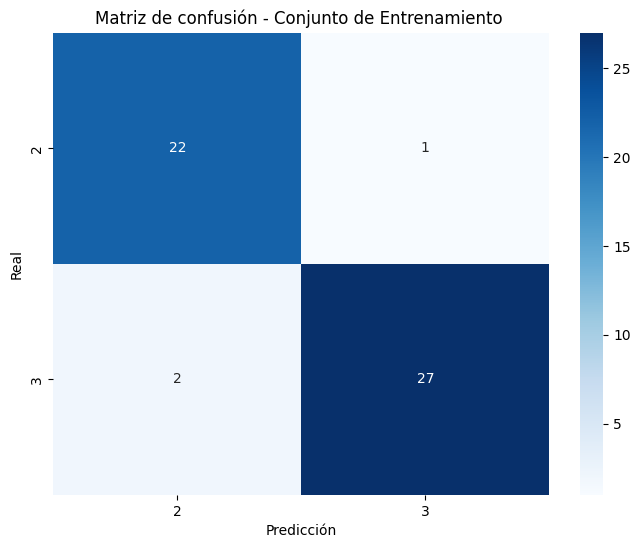

In [26]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

cm = confusion_matrix(y_train, y_test_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=np.unique(y), yticklabels=np.unique(y))
plt.title('Matriz de confusión - Conjunto de Entrenamiento ')
plt.xlabel('Predicción')
plt.ylabel('Real')
plt.show()

Variables mas importantes 

Características más importantes en BaggingClassifier:
Números con error espacial    0.086870
Ángulo manecillas 11am        0.075546
Puntuacion manecillas         0.071956
Circularidad                  0.061507
Manecillas diferentes         0.057717
Puntuacion numeros            0.054909
Round                         0.054229
Ángulo manecillas 2pm         0.052884
Manecilla 11 correcta         0.052348
Total numeros detectados      0.049518
dtype: float64


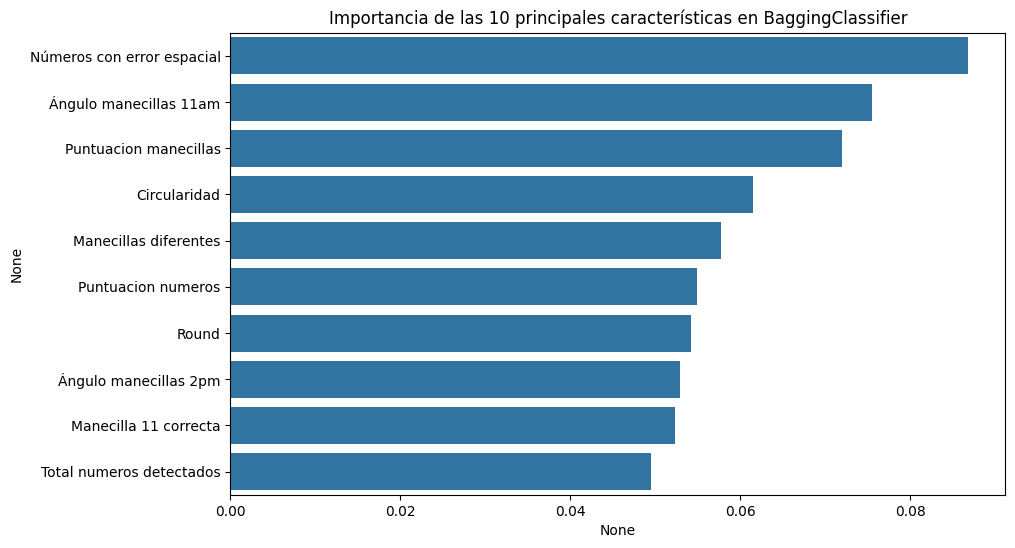

In [27]:
feature_importances = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)

importancias_bagging = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en BaggingClassifier:")
print(importancias_bagging.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_bagging.head(10), y=importancias_bagging.index[:10])
plt.title("Importancia de las 10 principales características en BaggingClassifier")
plt.show()


Características más importantes en CatBoostClassifier:
Puntuacion numeros                  10.297324
Area Circulo                         9.083249
Ángulo entre manecillas              8.372098
puntuacion final                     8.103716
Números detectados correctamente     7.475882
Números con error espacial           7.248449
longitud_relativa_11pm               6.971778
longitud_relativa_2pm                6.149720
Ángulo manecillas 2pm                5.408842
Ángulo manecillas 11am               5.229498
dtype: float64


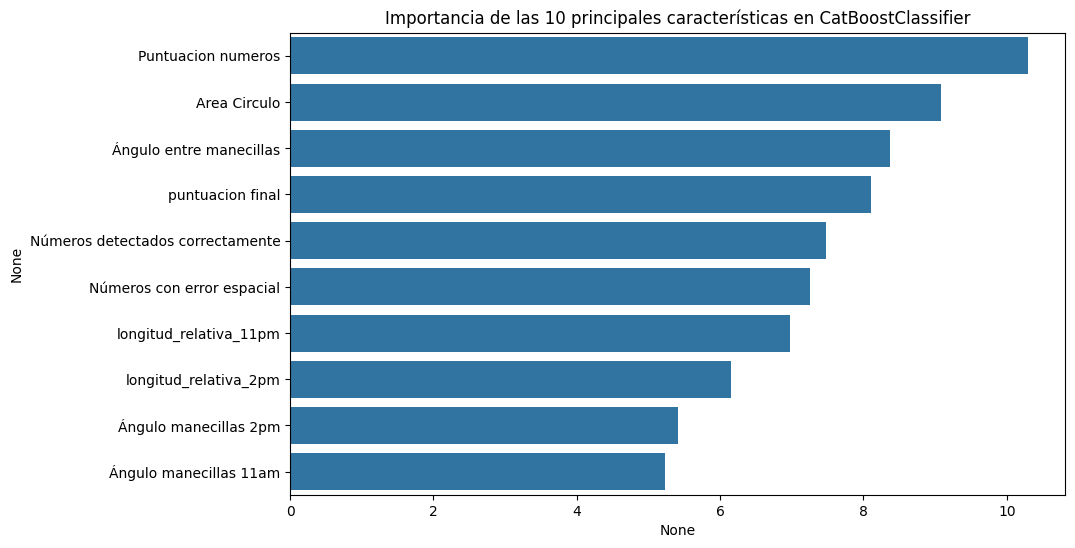

In [28]:
feature_importances = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances, index=X_train_full.columns).sort_values(ascending=False)

print("Características más importantes en CatBoostClassifier:")
print(importancias_catboost.head(10))

plt.figure(figsize=(10,6))
sns.barplot(x=importancias_catboost.head(10), y=importancias_catboost.index[:10])
plt.title("Importancia de las 10 principales características en CatBoostClassifier")
plt.show()

Importancias combinadas:
                           Variable  Importance_CatBoost  Importance_LGBM  \
0                      Area Circulo             0.881841              NaN   
1                      Circularidad             0.402657              NaN   
2             Manecilla 11 correcta             0.093236              NaN   
3              Manecilla 2 correcta             0.155764              NaN   
4             Manecillas diferentes             0.443740              NaN   
5            Números algo detectado             0.129310              NaN   
6        Números con error espacial             0.703271              NaN   
7  Números detectados correctamente             0.725405              NaN   
8               Puntuacion contorno             0.000000              NaN   
9             Puntuacion manecillas             0.073441              NaN   

   Importance_Bagging  
0            0.216910  
1            0.620387  
2            0.483301  
3            0.124253  
4      

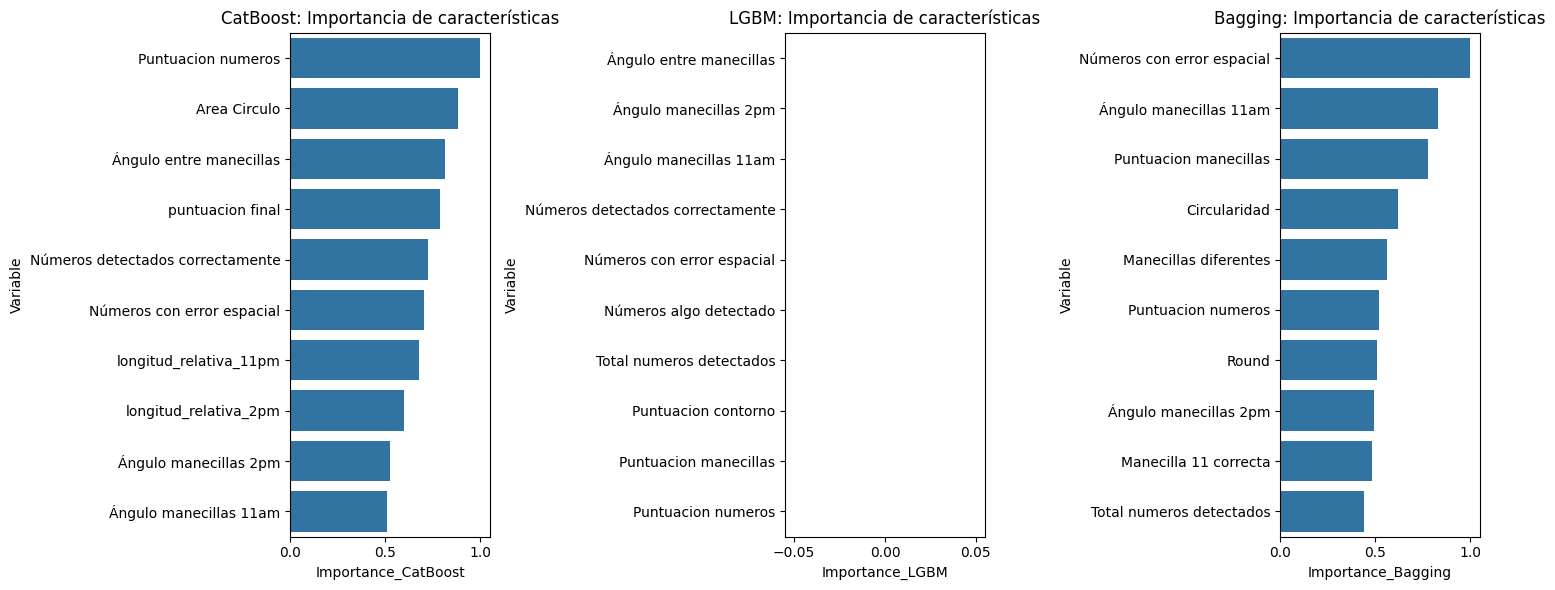

In [30]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

feature_importances_catboost = random_search_cat.best_estimator_.get_feature_importance()
importancias_catboost = pd.Series(feature_importances_catboost, index=X_train_full.columns)
importancias_catboost = (importancias_catboost - importancias_catboost.min()) / (importancias_catboost.max() - importancias_catboost.min())
importancias_catboost = importancias_catboost.sort_values(ascending=False)

df_importancias_catboost = pd.DataFrame({
    'Variable': importancias_catboost.index,
    'Importance_CatBoost': importancias_catboost.values
})

feature_importances_lgbm = random_search_lgbm.best_estimator_.feature_importances_
importancias_lgbm = pd.Series(feature_importances_lgbm, index=X_train_full.columns)
importancias_lgbm = (importancias_lgbm - importancias_lgbm.min()) / (importancias_lgbm.max() - importancias_lgbm.min())
importancias_lgbm = importancias_lgbm.sort_values(ascending=False)

df_importancias_lgbm = pd.DataFrame({
    'Variable': importancias_lgbm.index,
    'Importance_LGBM': importancias_lgbm.values
})

feature_importances_bagging = np.mean([
    tree.feature_importances_ for tree in random_search.best_estimator_.estimators_
], axis=0)
importancias_bagging = pd.Series(feature_importances_bagging, index=X_train_full.columns)
importancias_bagging = (importancias_bagging - importancias_bagging.min()) / (importancias_bagging.max() - importancias_bagging.min())
importancias_bagging = importancias_bagging.sort_values(ascending=False)

df_importancias_bagging = pd.DataFrame({
    'Variable': importancias_bagging.index,
    'Importance_Bagging': importancias_bagging.values
})

df_final = pd.merge(df_importancias_catboost, df_importancias_lgbm, on='Variable', how='outer')
df_final = pd.merge(df_final, df_importancias_bagging, on='Variable', how='outer')

print("Importancias combinadas:")
print(df_final.head(10))

kendall_corr = df_final[['Importance_CatBoost', 'Importance_LGBM', 'Importance_Bagging']].corr(method='kendall')
print("\nCorrelación de Kendall entre las importancias:")
print(kendall_corr)

plt.figure(figsize=(15, 6))
plt.subplot(1, 3, 1)
sns.barplot(x=df_importancias_catboost['Importance_CatBoost'].head(10), 
            y=df_importancias_catboost['Variable'].head(10))
plt.title("CatBoost: Importancia de características")

plt.subplot(1, 3, 2)
sns.barplot(x=df_importancias_lgbm['Importance_LGBM'].head(10), 
            y=df_importancias_lgbm['Variable'].head(10))
plt.title("LGBM: Importancia de características")

plt.subplot(1, 3, 3)
sns.barplot(x=df_importancias_bagging['Importance_Bagging'].head(10), 
            y=df_importancias_bagging['Variable'].head(10))
plt.title("Bagging: Importancia de características")

plt.tight_layout()
plt.show()
